In [28]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [5]:
file = './data/Musical_Instruments.jsonl'
dataset = []
with open(file, 'r') as fp:
    for line in fp:
        dataset.append(json.loads(line.strip()))

In [ ]:
df = pd.read_json('./data/Musical_Instruments.jsonl', lines=True)

In [25]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Five Stars,"Great headphones, comfortable and sound is goo...",[],B003LPTAYI,B003LPTAYI,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-01-13 02:03:06.000,0,True
1,3,nice sound. pedal failed after less than 1 year,I like the piano.. but the sustain pedal faile...,[],B00723436A,B06XP6TDVY,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-05-22 23:22:45.290,2,True
2,4,okay,pretty good overall. I like it. the controll...,[],B0040FJ27S,B0040FJ27S,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2013-11-20 01:54:42.000,0,True
3,3,Easy to return.,Too bad it didn't work. At least the return pr...,[],B00191WVF6,B00WJ3HL5I,AEM663T6XHZFWLODF4US2RCOCUSA,2020-12-04 04:21:33.671,0,True
4,5,Good product despite tight bolt.,Good and sturdy but the bolt was hell to get o...,[],B07T9NM5QR,B07T9NM5QR,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,2021-06-02 01:03:05.255,0,False


In [23]:
df.dtypes

rating                        int64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp            datetime64[ns]
helpful_vote                  int64
verified_purchase              bool
dtype: object

In [62]:
df[df['images'].apply(len)!=0]['images'].iloc[0]

[{'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71-Nm7DAvtL._SL256_.jpg',
  'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71-Nm7DAvtL._SL800_.jpg',
  'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71-Nm7DAvtL.jpg',
  'attachment_type': 'IMAGE'},
 {'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71enU8Ja9CL._SL256_.jpg',
  'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71enU8Ja9CL._SL800_.jpg',
  'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/71enU8Ja9CL.jpg',
  'attachment_type': 'IMAGE'},
 {'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/8114QHQmn0L._SL256_.jpg',
  'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/8114QHQmn0L._SL800_.jpg',
  'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/8114QHQmn0L.jpg',
  'attachment_type': 'IMAGE'}]

In [46]:
df.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

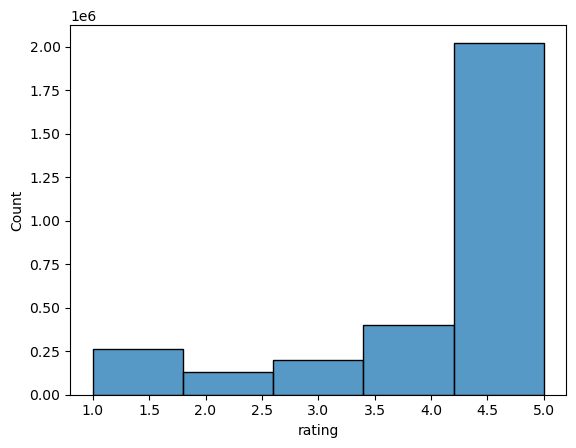

In [44]:
sns.histplot(df, x='rating', bins=5)

<Axes: xlabel='verified_purchase', ylabel='count'>

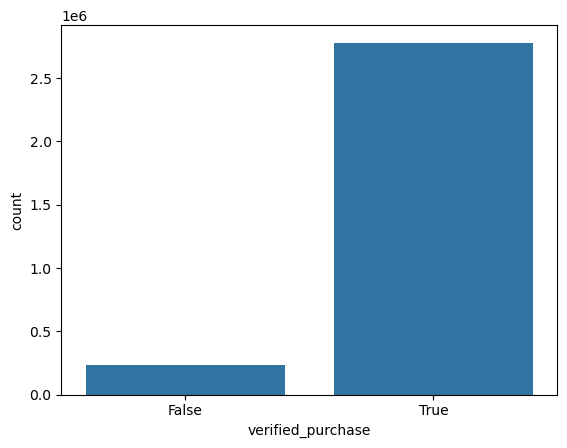

In [63]:
sns.countplot(df, x='verified_purchase')